In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter
import netwulf as nw

https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVcg

In [76]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])


In [77]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

pop_df, rap_df = split_artists_by_genre(nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)


(18232, 9397)

In [78]:
def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    return partition


In [79]:
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)


Number of nodes: 18085
Number of edges: 47851
Network density: 0.00029262269272440223
Number of nodes: 9320
Number of edges: 30560
Network density: 0.0007037171278209132


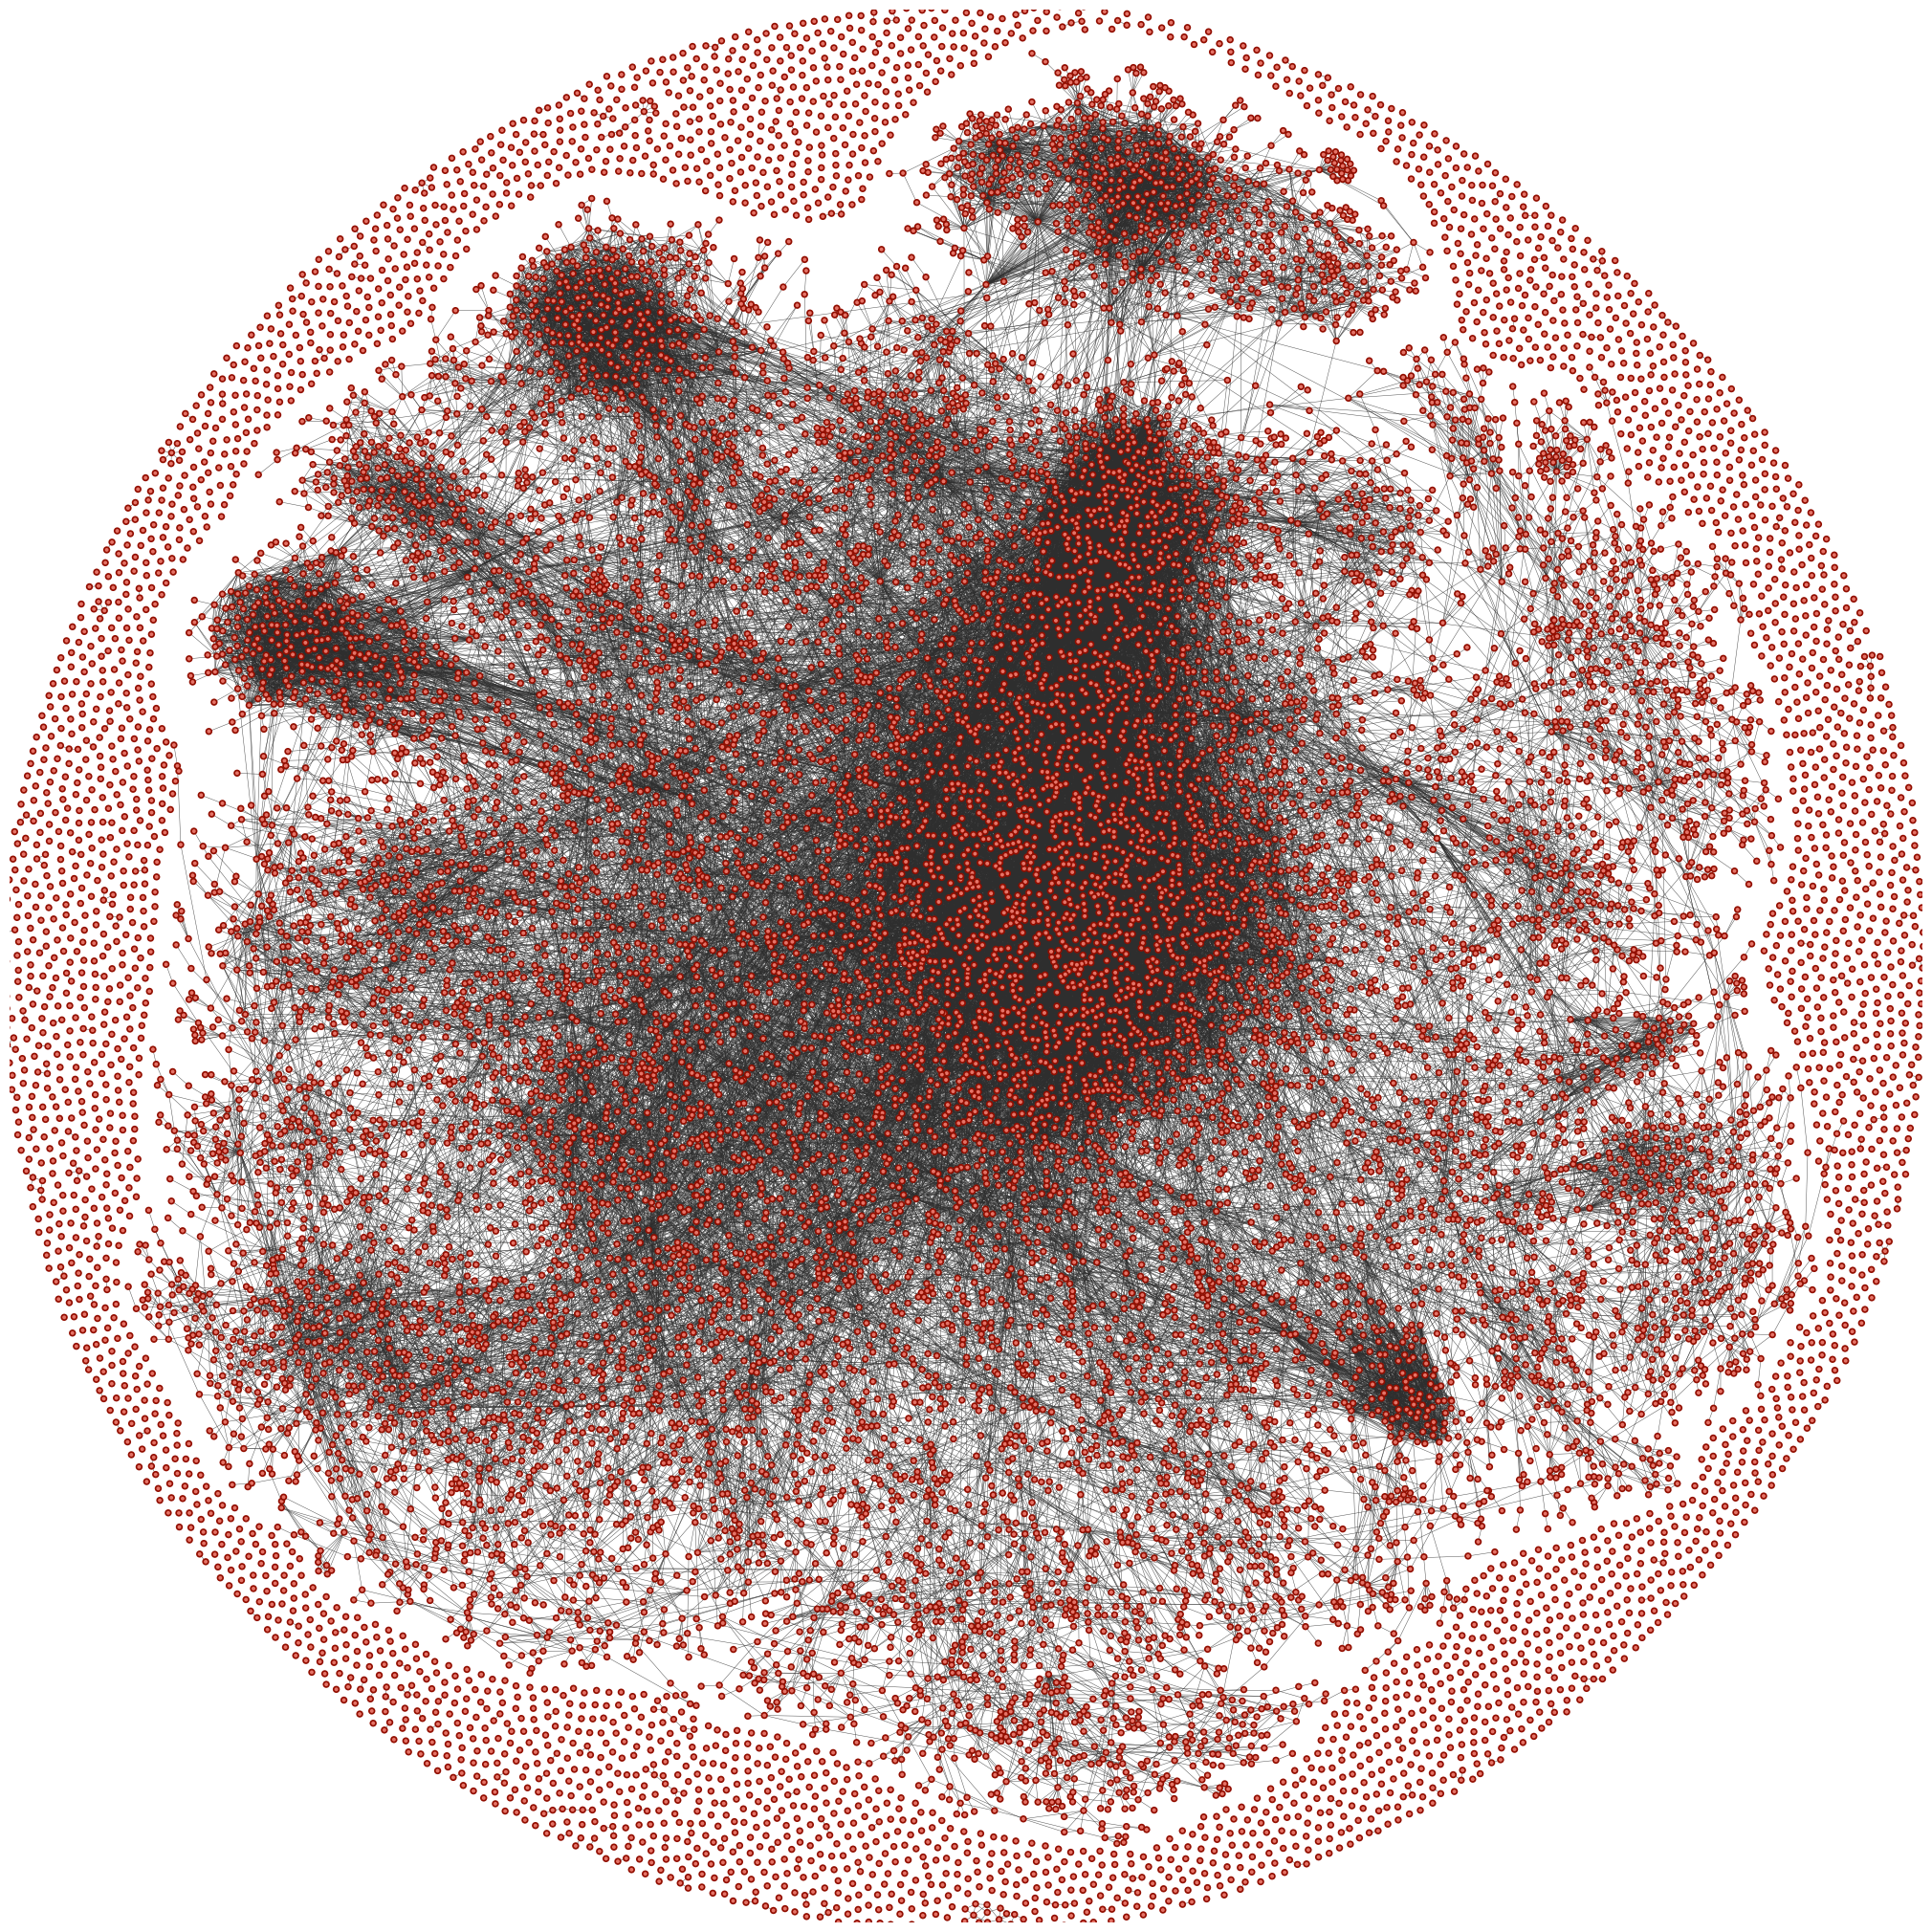

In [86]:
config_random_network = {
    # Input/output
    'zoom': 0.6,
    # Physics
    'node_charge': -47,
    'node_gravity': 0.27,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#e57468',
    'node_stroke_color': '#920e00',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': False,
    'node_size': 5,
    'node_stroke_width': 1,
    'node_size_variation': 0.5,
    # Links
    'link_color': '#2e2e2e',
    'link_width': 0.3,
    'link_alpha': 0.79,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': True,
    'min_link_weight_percentile': 0,
    'max_link_weight_percentile': 1
}


network, config = nw.visualize(G_pop, plot_in_cell_below=False, config=config_random_network)

fig, ax = nw.draw_netwulf(network, figsize=20)
plt.savefig("Network.pdf")


In [92]:
# Get degree (number of collaborations) for each artist
top_collaborators = sorted(G_pop.degree, key=lambda x: x[1], reverse=True)[:20]

# Print top 10
print("Top 10 artists with the most collaborations:")
for rank, (artist, degree) in enumerate(top_collaborators, start=1):
    print(f"{rank}. {artist} — {degree} collaborations")


Top 10 artists with the most collaborations:
1. R3HAB — 229 collaborations
2. Tiësto — 184 collaborations
3. David Guetta — 179 collaborations
4. Steve Aoki — 178 collaborations
5. Snoop Dogg — 167 collaborations
6. Diplo — 163 collaborations
7. Ty Dolla $ign — 162 collaborations
8. Gucci Mane — 159 collaborations
9. French Montana — 147 collaborations
10. Chris Brown — 136 collaborations
11. Lil Wayne — 135 collaborations
12. Pitbull — 131 collaborations
13. Major Lazer — 129 collaborations
14. MOTi — 117 collaborations
15. Sam Feldt — 114 collaborations
16. 2 Chainz — 113 collaborations
17. Wiz Khalifa — 113 collaborations
18. Rick Ross — 113 collaborations
19. Pritam — 110 collaborations
20. Afrojack — 107 collaborations


In [96]:
apply_louvain(G_rap)

AttributeError: module 'community' has no attribute 'best_partition'